In [1]:
import pickle
import numpy as np

import modularml as mml

# Getting Started

Constructing a full ModularML pipeline can be divided in to the following sub-tasks:
1. Defining FeatureSets
2. Constructing a ModelGraph
3. Creating the TrainingPhases
4. Running



This notebook provides an exmaple workflow for constructing a ML model to estimate battery state of health (SOH) using voltage-based features across a wide variety of aging conditions and state of charge (SOC). 


---
### 1 - Defining FeatureSets
---

The first step in creating a ModularML experiment is to outline the data structures. We need to decide on: 
* the data source to be used (your raw or preprocessed data),
* how the data should be structured into features, targets, and tags for modeling, and
* how the set of features should be split for different training stages (e.g., 'training', 'validation', 'testing')

Let's import some data. 
For this example, we will be using a set of preprocessed battery aging data from our recent paper: “Fine-tuning for rapid capacity estimation of lithium-ion batteries” ([10.1016/j.ensm.2025.104425](https://doi.org/10.1016/j.ensm.2025.104425)).

It contains short-duration (100-second) pulses applied to a battery over a long-term aging routine. More details can be found at the following GitHub repository: [REIL-UConn/fine-tuning-for-rapid-soh-estimation]{https://github.com/REIL-UConn/fine-tuning-for-rapid-soh-estimation.git}.

In [2]:
# Download the data from GitHub
import os
import urllib.request

DATA_URL = "https://raw.githubusercontent.com/REIL-UConn/fine-tuning-for-rapid-soh-estimation/main/processed_data/UConn-ILCC-NMC/data_slowpulse_1.pkl"
DATA_DIR = "downloaded_data"
DATA_PATH = os.path.join(DATA_DIR, "data_slowpulse_1.pkl")

# Create local directory
os.makedirs(DATA_DIR, exist_ok=True)

# Download if not already present
if not os.path.exists(DATA_PATH):
    print("Downloading data...")
    urllib.request.urlretrieve(DATA_URL, DATA_PATH)
    print("Download complete.")
else:
    print("Data already downloaded.")

Download complete.


In [3]:
# Loading our data
data = pickle.load(open(DATA_PATH, 'rb'))
print(data['cell_id'].shape, data['group_id'].shape, data['voltage'].shape, data['soh'].shape)
data.keys()

(24048,) (24048,) (24048, 101) (24048,)


/var/folders/21/fsx4ddjs3fg2wgpl7_ksh0k00000gn/T/ipykernel_63568/143080519.py:2: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  data = pickle.load(open(DATA_PATH, 'rb'))


dict_keys(['cell_id', 'group_id', 'rpt', 'num_cycles', 'soc', 'soc - coulomb', 'pulse_type', 'voltage', 'q_dchg', 'soh', 'dcir_chg_10', 'dcir_dchg_10', 'dcir_chg_20', 'dcir_dchg_20', 'dcir_chg_30', 'dcir_dchg_30', 'dcir_chg_40', 'dcir_dchg_40', 'dcir_chg_50', 'dcir_dchg_50', 'dcir_chg_60', 'dcir_dchg_60', 'dcir_chg_70', 'dcir_dchg_70', 'dcir_chg_80', 'dcir_dchg_80', 'dcir_chg_90', 'dcir_dchg_90'])

Here we see our initial data is structured a single dictionary. 
The FeatureSet class provides several constructors, including a `FeatureSet.from_dict` that we will use here.
We will need to decide on the dictionary keys that consitute our the features, targets, and tags to be used in the downstream modeling.

In this example, we will use `voltage` as our modeling input feature. Each `voltage` element is a 100-element vector of time-series voltage readings. Our target will be the `soh` (state-of-health) associated to each feature. To maintain sample traceability, and give us future options in how we split the data, we will retain several identifying tags with each sample. These include `cell_id`, `group_id`, `pulse_type`, and `pulse_soc`.

We see that the structured FeatureSet contains 24048 valid samples.

In [4]:
from modularml.core import FeatureSet

fs = FeatureSet.from_dict(
	label='PulseFeatures',
	data={
		'voltage': data['voltage'],
		'soh': data['soh'],
		'cell_id': data['cell_id'],
  		'group_id': data['group_id'],
    	'pulse_type': data['pulse_type'],
     	'pulse_soc': data['soc'],
	},
	feature_keys='voltage',
	target_keys='soh',
	tag_keys=['cell_id', 'group_id', 'pulse_type', 'pulse_soc']
)
fs

FeatureSet(label='PulseFeatures', n_samples=24048)

Now we want to split our full FeatureSet into several subsets. ModularML provides several built-in splitting methods, including:
* `FeatureSet.split_random()`: to create splits by assigning random proportions of all samples to each split
* `FeatureSet.split_by_condition()`: to assign samples to subsets using any number of explicit conditions.

To use a random 50% train, 30% valdation, 20% test split, we could do the following:

In [5]:
fs.split_random(ratios={'train': 0.5, 'val':0.3, 'test':0.2})

[FeatureSubset(label='train', n_samples=12024),
 FeatureSubset(label='val', n_samples=7214),
 FeatureSubset(label='test', n_samples=4810)]

But to better evaluate how good our SOH-estimation model really is, we'll want to isolate the train and test sets by unique cycling conditions. Therefore, we are testing how well our model can estimate SOH even when applied to unseen cycling conditions. 

Let's clear those subsets and create a more effective splitting strategy:

In [6]:
fs.clear_subsets()
fs.available_subsets

dict_keys([])

The `FeatureSet.available_subset` attribute is useful for double-checking which subsets are available.

In our data, unique cycling conditions are indentified by the `group_id` tag (a value between 1 and 11). We can easily double check the available tags information using `FeatureSet.get_all_tags`. This function allows for the returned information to be structured in several way (e.g., a Pandas dataframe, a dictionary, a numpy array, etc). We'll use a dataframe.

In [7]:
df_tags = fs.get_all_tags(format=mml.DataFormat.PANDAS)
df_tags.groupby('group_id').size()
group_counts = df_tags.groupby('group_id').size()
print(group_counts)

group_id
1     2196
2     1962
3     2898
4     1206
5     3852
6     1890
7      954
8     4752
9      738
10    1494
11    2106
dtype: int64


Great, we see that `group_id` tag has 11 unique values. 
Note that there are a different number of samples in each group (this is due to different cycling condition resulting in faster or slower aging). 
We will adjust for this sample imbalance later.

Back to splitting, we will take 6 cycling groups for training, 3 for validation, and 2 for testing.
Let's make a quick helper function to random select the group_ids for each subset.

In [8]:
def get_group_ids(train_size:int, val_size:int, test_size:int):
    group_ids = np.arange(1, 12, 1)
    # Shuffle the groups
    rng = np.random.default_rng(seed=13)
    rng.shuffle(group_ids)
    
    a, b = train_size, train_size + val_size
    return group_ids[:a], group_ids[a:b], group_ids[b:]

train_ids, val_ids, test_ids = get_group_ids(train_size=6, val_size=3, test_size=2)
print("Train IDs: ", train_ids)
print("Val IDs: ", val_ids)
print("Test IDs: ", test_ids)

Train IDs:  [7 2 6 1 5 8]
Val IDs:  [3 9 4]
Test IDs:  [11 10]


To split, we'll use `FeatureSet.split_by_condition` and define the explicit `group_id` values to assign to each subset.

In [9]:
fs.get_all_tags()

{'cell_id': array([ 1,  1,  1, ..., 44, 44, 44]),
 'group_id': array([ 1,  1,  1, ..., 11, 11, 11]),
 'pulse_type': array(['chg', 'dchg', 'chg', ..., 'dchg', 'chg', 'dchg'], dtype='<U4'),
 'pulse_soc': array([10, 10, 20, ..., 80, 90, 90])}

In [10]:
fs.split_by_condition(
	train={'group_id': train_ids},
	val={'group_id': val_ids},
	test={'group_id': test_ids}
)

[FeatureSubset(label='train', n_samples=15606),
 FeatureSubset(label='val', n_samples=4842),
 FeatureSubset(label='test', n_samples=3600)]

We can also plot a quick Sankey diagram to view our subsets.
This exmaple is fairly straight forward, but ModularML allows for an unlimited number of nested subsets to be created within a single FeatureSet object.
In these cases, the Sankey diagram becomes much more useful to visual the flow of samples into subsets. 

In [11]:
fs.plot_sankey()

# COMING SOON: Adding FeatureTransform Logic

The FeatureTransform class encapsulates all feature/target scaling and normalization methods.
Its wraps all available scalers from `sklearn.preprocessing` and provides easy integration with the `FeatureSet` class.

Apply transforms to the underlying features in FeatureSet are as easy as: 
``` python
FeatureSet.fit_transform(fit='features', apply='features', transform=FeatureTransform(...))
```
Here we fit the transform object to `fit='features'` (i.e., fit to all features in the FeatureSet), and applied it to `apply='features'` (i.e., apply to all features in the FeatureSet).

However, to prevent data leakage in ML workflow, it is required that any data transform be fit only to the training set.
This can be accomplished with a simple adjustment of the `fit` argument: 
``` python
FeatureSet.fit_transform(fit='train.features', apply='features', transform=FeatureTransform(...))
```
Now, the transform is only fit to all features in the train subset (`fit='train.features'`).

Note that all data access methods of FeatureSet (e.g., `.get_all_features()`) will return the transformed versions of the data by default.
Receiving the unscaled data can be achieved by using the `scaled` argument of the data access methods (e.g., `.get_all_features(scaled=False)`).

Additionally, theunderlying transform in the `FeatureTransform(...)` object passed to `FeatureSet.fit_transform(...)` is not mutated.
A copy is made and stored internal to FeatureSet.
Accessing the fit tranforms is achieved with the `FeatureSet.available_transform` property. This returns a list of fit FeatureTransform objects.

They can be reused later without re-fitting using the `.transform()` method of `FeatureSet`:
``` python
fs = FeatureSet(...)
my_transform = fs.available_transforms[0]
fs.transform(apply='new_subset.features', transform=my_transform)
```
Here we applied the transform to the features in some other subset (`new_subset`).

Now that we have our main FeatureSet and corresponding subsets, let's move on to step 2.

---
### 2 - Building a ModelGraph
---

One of most powerful aspects of ModularML is its directed-acyclic-graph (DAG)-based ModelGraph container.
It allows for any number of ModelStages to be linked together into a larger structure.
Even better, each ModelStage can have any backend (e.g., PyTorch, Tensorflow/Keras, Scikit-learn).
This lets you defined a complex multi-objective evaluation pipeline all under a unified ModelGraph.

But let's stop talking and get back to modeling...

In this example, we'll create a multi-stage model that uses a CNN encoder to embed the voltage features into some learned latent space and a final MLP regressor to convert the embedded feature into an SOH estimate.

ModularML provides pre-built classes for the more commonly used model like sequential CNNs and MLPs. We'll use those here, but any custom model can be easily defined. All you need to do is subclass the `modularml.BaseModel` class and defined the required methods.

With complex ModelGraphs, it can get annoying to keep track of input/output shape of each ModelStage.
Don't worry, ModularML can infer these for you at runtime.
Just leave any shapes you don't know as None and ModularML will handle the rest.


In [12]:
from modularml.core import StageInput, ModelStage, ModelGraph, Optimizer
from modularml.models import SequentialCNN, SequentialMLP


ms_encoder = ModelStage(
	model=SequentialCNN(output_shape=(1, 32), n_layers=2, hidden_dim=16, flatten_output=True),
	label="Encoder",
	inputs=StageInput(source='PulseFeatures'),				# input from FeatureSet
	optimizer=Optimizer(name='adam', backend=mml.Backend.TORCH)
)

ms_regressor = ModelStage(
	model=SequentialMLP(output_shape=(1,1), n_layers=2, hidden_dim=16),
 	label='Regressor',
  	inputs=StageInput(source='Encoder'),					# input from Encoder
	optimizer=Optimizer(name='adam', backend=mml.Backend.TORCH)
)

With the ModelStages defined, we simply need to pass them all to a single ModelGraph instance.

The ModelGraph will handle all data routing and shape inference with the `.build_all()` method.

In [13]:
# Order of node arguments don't matter but make sure you include any 
# FeatureSets referenced by any ModelStage.inputs
mg = ModelGraph(nodes=[fs, ms_regressor, ms_encoder, ])
mg.build_all()

Inferred shapes for `Encoder`:  torch.Size([1, 101]) -> (1, 32)
Inferred shapes for `Regressor`:  (1, 32) -> (1, 1)


Lets run a temporary forward pass to make sure everythings connected properly.

ModelGraph builds in a connection test with `.dummy_forward()`

In [14]:
mg.dummy_foward(batch_size=8)

[[[-0.20918120443820953]],
 [[-0.20918120443820953]],
 [[-0.20918120443820953]],
 [[-0.20918120443820953]],
 [[-0.20918120443820953]],
 [[-0.20918120443820953]],
 [[-0.20918120443820953]],
 [[-0.20918120443820953]]]

ModelGraph also has a built in visualization method to view all node connection, although it's not too exciting for this example.

(<Figure size 600x300 with 1 Axes>, <Axes: >)

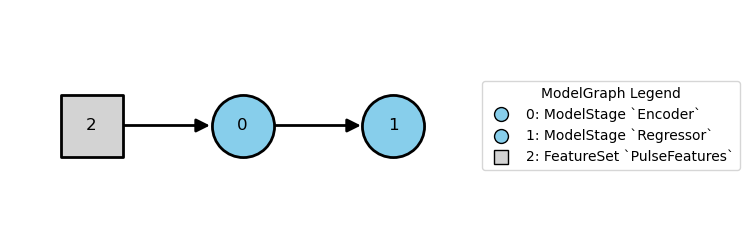

In [15]:
mg.visualize()